In [1]:
import numpy as np
import numpy.random as npr
from scipy import sparse
from scipy.spatial.distance import cosine
from time import time

from matplotlib import pyplot as plt
from matplotlib import animation, rc, collections
from IPython.display import HTML

np.set_printoptions(precision=3)

Here are all the functions from the walkthrough in a single block:

In [2]:
def get_weights_motifs(shape, prob, split=.9, core=.4):
    """Return a weights matrix with prob amount of random connections activated.
    
    Args:
        shape: (int) number of neurons in network
        prob: (float) fraction of connections to be activated
    
    Returns:
        weights: (numpy matrix) connectivity weight matrix
    """
    # THIS IS NOT QUITE RANDOM...
    l = int(shape*shape*prob)
    l_split = int(l * split)
    shape_split = int(shape * core)
    rows_core = npr.choice(range(shape_split), l_split)
    cols_core = npr.choice(range(shape_split), l_split)
    rows_all = npr.choice(range(shape), l - l_split)
    cols_all = npr.choice(range(shape), l - l_split)
    rows = np.concatenate((rows_core, rows_all))
    cols = np.concatenate((cols_core, cols_all))
    weights = sparse.csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(shape,shape))
    weights.setdiag(0)
    return weights

def get_weights_rand(shape, prob):
    """Return a weights matrix with prob amount of random connections activated.
    
    Args:
        shape: (int) number of neurons in network
        prob: (float) fraction of connections to be activated
    
    Returns:
        weights: (numpy matrix) connectivity weight matrix
    """
    # THIS IS NOT QUITE RANDOM...
    l = int(shape*shape*prob)
    rows = npr.choice(range(shape), l)
    cols = npr.choice(range(shape), l)
    weights = sparse.csr_matrix((np.ones(l), (rows, cols)), shape=(shape,shape))
    weights.setdiag(0)
    return weights

def get_patterns(activity, num_neurons, num_patterns):
    """Return a matrix where each row is a pattern with activity level activity.
    
    Args:
        activity: (float) avg activity level per pattern
        num_neurons: (int) num neurons in network
        num_patterns: (int) num patterns to generate
    
    Returns:
        patterns: (numpy matrix) set of patterns shape=(num_patterns, num_neurons)
    """
    return npr.binomial(1, activity, size=(num_patterns, num_neurons))

def get_syn_weights(patterns):
    """Return synaptic weight matrix.
    
    Args:
        patterns: (numpy matrix) set of patterns, shape=(num_patterns, num_neurons)
        
    Returns:
        syn: (numpy matrix) synaptic weight matrix, shape=(num_neurons, num_neurons)
    """
    num_patterns, num_neurons = patterns.shape
    row_ind = []
    col_ind = []
    for i in range(num_patterns):
        p = sparse.csr_matrix(patterns[i, :])
        mat = p.multiply(p.T)
        rows, cols = np.nonzero(mat)
        row_ind = np.concatenate([row_ind, rows])
        col_ind = np.concatenate([col_ind, cols])
    o = np.ones(len(row_ind))
    return sparse.csr_matrix((o, (row_ind, col_ind)), shape=(num_neurons, num_neurons))

def get_degraded_pattern(pattern, valid, spurious):
    """Return degraded pattern for input to simulation to do pattern completion.
    
    Args:
        pattern: (array) pattern to degrade, 0s or 1s, shape=(num_neurons)
        valid: (float) fraction of valid firing neurons
        spurious: (float) fraction of spurious firing neurons
    
    Return:
        deg_pat: (array) degraded pattern, 0s or 1s, shape=(num_neurons)
    """
    fires = np.nonzero(pattern)[0]
    deg_fires = npr.choice(fires, size=int(valid*len(fires)), replace=False)

    nonfires = np.where(pattern == 0)[0]
    spur_fires = npr.choice(nonfires, size=int(spurious*len(nonfires)), replace=False)
    
    all_fires = np.concatenate((deg_fires, spur_fires), axis=0)

    deg_pat = np.zeros(shape=(len(pattern),))
    deg_pat[all_fires] = 1
    
    return deg_pat

def get_correlation(p1, p2):
    if sum(p1) == 0 or sum(p2) == 0:
        return 0
    p1_ = p1 - (sum(p1)/len(p1))
    p2_ = p2 - (sum(p2)/len(p2))
    return 1 - cosine(p1_, p2_)

def simulate(in_pattern, out_pattern, con_mat, syn_mat, g0, g1, cycles=10, pprint=False):
    """Return final matrix of updates.
    
    Args:
        in_pattern: (array) degraded pattern to start
        out_pattern: (array) original pattern to attempt to recall
        con_mat: (matrix) connectivity matrix
        syn_mat: (matrix) synaptic weights matrix
        g0: (float) firing threshold
        g1: (float) inhibition factor
        cycles: (int) num times to run iteration
    
    Return:
        curr_mat: (matrix) end state matrix
    """
    n = len(in_pattern)
    W_J = con_mat.multiply(syn_mat)
    state = sparse.csr_matrix(np.matrix(in_pattern)).T
    if pprint:
        print('{:<10} {:<10} {:<10}'.format('steps', 'correl', 'num fires'))
    for i in range(cycles):
        if pprint:
            curr = state.T.toarray()[0]
            print('{:<10} {:<10.2f} {:<10}'.format(i, get_correlation(curr, out_pattern), sum(curr)))
        _inter = W_J.dot(state)
        h = (1/n) * _inter
        condition = h - ( (1/n) * g1 * np.sum(state) )
        state = condition > g0
        state = _inter > 0.
    curr = state.T.toarray()[0]
    return get_correlation(curr, out_pattern)

Let's make the main connectivity matrix, as that takes the longest and we can't hold more than one in memory at a time:

In [52]:
n = 100000                 # number of neurons in network; CA3 is 330,000 (or double)
p = .04                    # connection probability for weight matrix
v = 'Motif'                # string modifier for saved results

now = time()
W = get_weights_motifs(n, p) # connectivity weight matrix; are neurons connected?
print('p: {}, made W in {}'.format(p, time() - now))

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


p: 0.04, made W in 327.3439438343048


Now let's degrade a pattern, and have a look at what a degraded pattern looks like:

In [53]:
f = 0.001                      # average activity level of each pattern
m_rng = [1, 5, 10, 50, 100]    # number of patterns to store

b_vald = .5                    # fraction of valid firing neurons in patterns
b_spur = 0.001                 # fraction of spurious firing neurons in patterns

loops = 10
init = np.zeros((loops, len(m_rng)))
finl = np.zeros((loops, len(m_rng)))

for i in range(loops):
    print(i, end=' ', flush=True)
    init_corr = []                 # list to store original correlation for each m value
    finl_corr = []                 # list to store 'completed' correlation for each m value

    for m in m_rng:
        M = get_patterns(f, n, m)  # patterns
        J = get_syn_weights(M)     # synaptic weight matrix J; how much are neurons connected?
        W_J = W.multiply(J)

        pattern = M[0, :]
        badpat = get_degraded_pattern(pattern, b_vald, b_spur)
        init_corr.append(get_correlation(pattern, badpat))

        g_0 = n/3
        g_1 = 0.0
        res = simulate(badpat, pattern, W, J, g_0, g_1, cycles=10)
        finl_corr.append(res)

    init[i, :] = init_corr
    finl[i, :] = finl_corr

np.savetxt('results/p{}finlcorr{}.txt'.format(p, v), finl)
np.savetxt('results/p{}initcorr{}.txt'.format(p, v), init)

0 1 2 3 4 5 6 7 8 9 

In [45]:
finl = np.loadtxt('results/p{}finlcorr{}.txt'.format(p, v))
init = np.loadtxt('results/p{}initcorr{}.txt'.format(p, v))

init_avg = np.sum(init, axis=0)/loops
finl_avg = np.sum(finl, axis=0)/loops

print(init_avg)
print(finl_avg)

[ 0.403  0.402  0.4    0.404  0.412]
[ 0.671  0.612  0.597  0.164  0.069]


In [54]:
p_rng = [0.01, 0.02, 0.03, 0.04, 0.05]
corr_pln = np.zeros((len(p_rng), len(m_rng)))
corr_mtf = np.zeros((len(p_rng), len(m_rng)))

for i, p in enumerate(p_rng):
    finl = np.loadtxt('results/p{}finlcorr.txt'.format(p))
    finl_avg = np.sum(finl, axis=0)/loops
    corr_pln[i, :] = finl_avg
    print(p, finl_avg)

    finl = np.loadtxt('results/p{}finlcorrMotif.txt'.format(p))
    finl_avg = np.sum(finl, axis=0)/loops
    corr_mtf[i, :] = finl_avg
    print(p, finl_avg, 'with motifs')

0.01 [ 0.746  0.732  0.671  0.476  0.37 ]
0.01 [ 0.523  0.523  0.368  0.253  0.119] with motifs
0.02 [ 0.889  0.744  0.728  0.242  0.127]
0.02 [ 0.671  0.612  0.597  0.164  0.069] with motifs
0.03 [ 0.976  0.639  0.64   0.174  0.096]
0.03 [ 0.918  0.736  0.574  0.154  0.087] with motifs
0.04 [ 0.992  0.825  0.623  0.141  0.093]
0.04 [ 0.709  0.677  0.542  0.129  0.07 ] with motifs
0.05 [ 0.385  0.282  0.291  0.201  0.127]
0.05 [ 0.756  0.698  0.479  0.124  0.073] with motifs


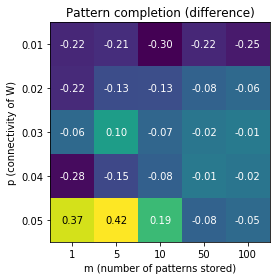

In [64]:
fig, ax = plt.subplots()

ax.set_title("Pattern completion (difference)")
data = corr_mtf - corr_pln
# data = corr_mtf
im = ax.imshow(data)

# We want to show all ticks...
ax.set_xticks(np.arange(len(m_rng)))
ax.set_yticks(np.arange(len(p_rng)))
# ... and label them with the respective list entries
ax.set_xticklabels(m_rng)
ax.set_yticklabels(p_rng)
ax.set_ylabel('p (connectivity of W)')
ax.set_xlabel('m (number of patterns stored)')

# Loop over data dimensions and create text annotations.
for i in range(len(p_rng)):
    for j in range(len(m_rng)):
        if data[i, j] > .3:
            text = ax.text(j, i, '{:.2f}'.format(data[i, j]),
                       ha="center", va="center", color="k")
        else:
            text = ax.text(j, i, '{:.2f}'.format(data[i, j]),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.show()